In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


In [2]:
df_log = pd.read_csv("CGS_data/data/SRP073813/SRP073813_log.csv")
df_meta = pd.read_csv("CGS_data/data/SRP073813/SRP073813_meta.csv")

In [3]:
df_log.set_index("HUGO", inplace = True)
df_meta.set_index("ID", inplace = True) #Setting the index for data makes the enrichment analysis easier
df_meta = df_meta['refinebio_subject'] #removes unnecessary data 

In [4]:
df_meta = df_meta.to_frame()

In [5]:
df_log =round(df_log) 
df_log = df_log.T #swaps columns and indexes
df_log = df_log.join(df_meta)

In [6]:
df_log = df_log.loc[:, ~df_log.columns.duplicated()] #removes duplicate columns prevent deseq

In [7]:
#Transfomring the data to contain only data collected from a certain part of the brain in our patients 
df_log = df_log[df_log["refinebio_subject"].str.contains('nacc')]
df_meta = df_meta[df_meta["refinebio_subject"].str.contains('nacc')] 

In [8]:
df_log.drop("refinebio_subject",axis =1,inplace = True)

In [9]:
df_log = df_log.T

In [10]:
#get variacne sort by it and select the top ones to do Hclust on
df_log["variance"] = np.var(df_log.values, axis=1)
df = df_log.sort_values("variance", ascending=False)
df.drop("variance", axis =1, inplace = True)
dfTen = df.head(10).T
dfHun = df.head(100).T
dfThous = df.head(1000).T
dfTenThous = df.head(10000).T
dfFiveThous = df.head(5000).T


In [11]:
dfFiveThous = dfFiveThous.join(df_meta)
dfTen = dfTen.join(df_meta)
dfHun = dfHun.join(df_meta)
dfThous = dfThous.join(df_meta)
dfTenThous = dfTenThous.join(df_meta)

In [12]:
def create_model(df):
    y = df.refinebio_subject
    cols = np.delete(df.columns, len(df.columns)-1,0)
    X = df[cols]
    forest_model = RandomForestClassifier(random_state=1)
    train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.5, random_state=1)
    forest_model.fit(train_X,train_y)
    y_pred = forest_model.predict(val_X)
    accuracy = accuracy_score(val_y, y_pred)
    print(f"{len(df.columns)-1} Genes Accuracy: {accuracy:.2f}")
    forest_model.fit(X,y)
    return forest_model
    

In [13]:
tenModel =create_model(dfTen)
hunModel = create_model(dfHun)
thousModel=create_model(dfThous)
fiveThousModel=create_model(dfFiveThous)
tenThousModel = create_model(dfTenThous)

10 Genes Accuracy: 0.40
100 Genes Accuracy: 0.39
1000 Genes Accuracy: 0.40
5000 Genes Accuracy: 0.49
10000 Genes Accuracy: 0.35


In [14]:
cols = np.delete(dfFiveThous.columns, len(dfFiveThous.columns)-1,0)
X = dfFiveThous[cols]

In [15]:
def extract_genes(df,model, threshold):
    gene_names = np.delete(df.columns, len(df.columns)-1,0)
    importances = model.feature_importances_
    significant_genes_rf = [gene_names[i] for i, importance in enumerate(importances) if importance > threshold]
    return significant_genes_rf

In [60]:
sig_10 = set(extract_genes(dfTen, tenModel, 0.0015))
sig_100 = set(extract_genes(dfHun, hunModel, 0.0015))
sig_1000 = set(extract_genes(dfThous, thousModel, 0.0015))
sig_5000 =set(extract_genes(dfFiveThous, fiveThousModel, 0.0015))
sig_10000 = set(extract_genes(dfTenThous,tenThousModel, 0.0015))

C:\Users\Shlok\AppData\Local\Programs\Python\Python310\lib\site-packages\venn\_backwards_compatibility.py:15: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead
  warn((
C:\Users\Shlok\AppData\Local\Programs\Python\Python310\lib\site-packages\venn\_backwards_compatibility.py:30: UserWarning: `venn5()` is retained for backwards compatibility; use `venn()` instead
  warn((


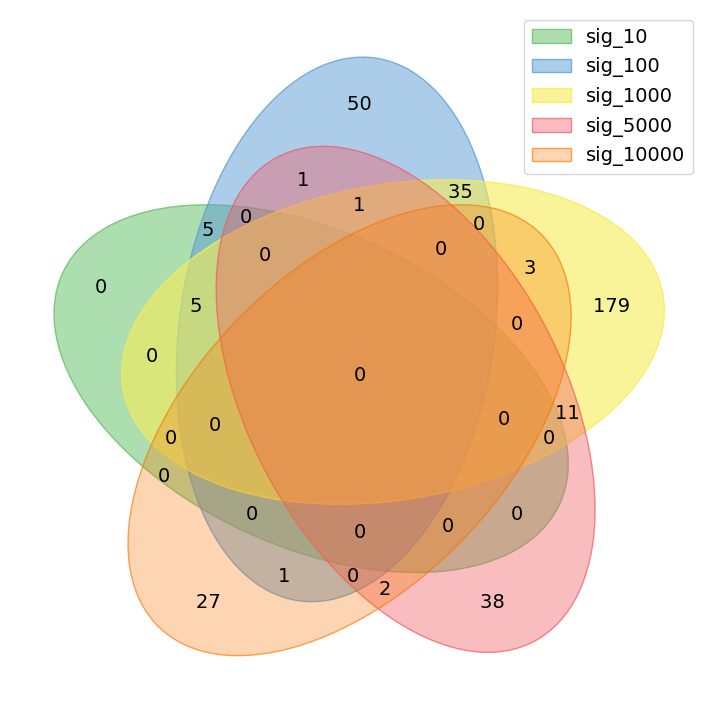

In [65]:
import venn

# Define your sets
sets = {
    'sig_10': set(sig_10),
    'sig_100': set(sig_100),
    'sig_1000': set(sig_1000),
    'sig_5000': set(sig_5000),
    'sig_10000': set(sig_10000)
}

# Create the Venn diagram
labels = venn.get_labels([value for key, value in sets.items()], fill=['number'])
fig, ax = venn.venn5(labels, names=list(sets.keys()))
